# Introduction
We have recieved dataset containing information phishing URLs. Dataset contains list of URLs, URL has SSL, URL allows SQL injection, URL have cert ver, URL allows inp val and whether URL is UNSAFE or not. We'll be dividing dataset into train, validation and test sets. Train set will be used for training and validation set for validation of trained model. We'll then use test set for testing once whole model has completed training.

We'll be trying LSTM and Dense Net for our purpose. We'll first tokenize data using various stratgies like count vectorizer, tfidf, frequency of words etc. We also have used first layer as embedding layer for our LSTM model to create embedding for words.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image ## Library for loading images
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.regularizers import l1, l2
from keras.utils import plot_model

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from IPython.display import FileLink
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Using TensorFlow backend.


# Loading & Cleaning Data
We have loaded data in pandas dataframe and then we remove all rows which has any NAN to avoid issues during training.

In [2]:
df = pd.read_csv('csv_result-Phishing_Legitimate_full.csv') ## Change here based on where is file on your local
df = df.dropna() ## Here we are removing any rows which has NaNs. We can't train model with Nan values else it'll fail.
print(df.shape)
df.head() ## Printing first 5 columns of dataset

(10000, 50)


,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,1,3,1,5,72,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,2,3,1,3,144,0,0,0,0,2,...,0,0,0,1,-1,1,1,1,1,1
2,3,3,1,2,58,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1
3,4,3,1,6,79,1,0,0,0,0,...,0,0,0,1,-1,1,1,1,-1,1
4,5,3,0,4,46,0,0,0,0,0,...,1,0,0,1,1,-1,0,-1,-1,1


In [3]:
df.tail() ## Printing last 5 columns of dataset.

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
9995,9996,3,1,1,50,0,0,0,0,0,...,0,0,0,1,1,-1,1,0,1,0
9996,9997,2,1,4,59,1,0,0,0,0,...,1,0,0,1,0,0,1,0,1,0
9997,9998,2,1,4,57,0,0,0,0,0,...,0,0,0,1,0,1,1,0,1,0
9998,9999,3,1,1,49,0,0,0,0,0,...,1,0,0,1,1,0,1,0,1,0
9999,10000,3,1,2,52,3,0,0,0,0,...,0,0,0,1,1,1,1,1,1,0


In [4]:
def plot_confusion_matrix(actuals, preds):
    conf_mat = confusion_matrix(Y_test, preds)
    with plt.style.context(('seaborn', 'ggplot')):
        plt.figure(figsize=(5,5))
        plt.imshow(conf_mat, cmap=plt.cm.Blues)
        plt.xticks(range(2), range(2))
        plt.yticks(range(2), range(2))
        plt.grid(None)
        plt.ylabel('Actual')
        plt.xlabel('Prediction')
        plt.colorbar();
        for i in range(conf_mat.shape[0]):
            for j in range(conf_mat.shape[1]):
                plt.text(j, i, str(conf_mat[i, j]), horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
        plt.savefig('conf_mat.png')

def plot_loss_and_accuracy(hist):
    with plt.style.context(('seaborn', 'ggplot')):
        plt.figure(figsize=(12,5))
        plt.subplot(121)
        plt.plot(hist.history['loss'], label='Train Loss')
        plt.plot(hist.history['val_loss'], label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='best')
        
        plt.subplot(122)
        plt.plot(hist.history['accuracy'], label='Train Accuracy')
        plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='best')
        plt.savefig('loss_and_acc.png')
            
def train_and_evaluate_model(model_type, model, loss='binary_crossentropy', optimizer='adam', batch_size=32, epochs=10, validation_split=0.1, figures=False, verbose=0):
    #print('\nCompiling Model')
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) # Compiling Model
    #print('\nTraining Model\n')
    if model_type=='DenseNet':
        hist = model.fit(X_train, Y_train, batch_size=32, epochs=epochs, validation_split=validation_split, verbose=verbose) ## Fitting Model
    else:
        hist = model.fit(X_train.reshape((X_train.shape[0],1,X_train.shape[1])), Y_train, batch_size=32, epochs=epochs, validation_split=validation_split, verbose=verbose) ## Fitting Model
    
    if figures:
        plot_loss_and_accuracy(hist)
        if model_type == 'DenseNet':
            plot_confusion_matrix(Y_test, model.predict_classes(X_test))
        else:
            plot_confusion_matrix(Y_test, model.predict_classes(X_test.reshape((X_test.shape[0],1,X_test.shape[1]))))
        
    ## Evaluating Model
    if model_type == 'DenseNet':
        test_loss, test_acc = model.evaluate(X_test, Y_test, batch_size=64, verbose=verbose)
        train_loss, train_acc = model.evaluate(X_train, Y_train, batch_size=64, verbose=verbose)
    else:
        test_loss, test_acc = model.evaluate(X_test.reshape((X_test.shape[0],1,X_test.shape[1])), Y_test, batch_size=64, verbose=verbose)
        train_loss, train_acc = model.evaluate(X_train.reshape((X_train.shape[0],1,X_train.shape[1])), Y_train, batch_size=64, verbose=verbose)
    print('\nTest Loss: %.3f'%test_loss)
    print('Train Loss: %.3f'%train_loss)
    print('Test accuracy: %.2f'%(test_acc*100))
    print('Train accuracy: %.2f'%(train_acc*100))
    return test_loss, test_acc, train_loss, train_acc

# 1. LSTM Model v1
Below we have defined our first LSTM model. Our model consist of 2 layers(LSTM & Dense). LSTM layers consist of 32 units. Here units generally refers to that many nodes in that layers. Dropout are introduced to prevent model from overfitting. Dropout of 0.2 ignores 20% of outputs and set them to 0 before giving it as input to next layer. Dense layer consist of 1 unit with activation function as sigmoid which will transfer LSTM’s output in range (0,1.0) which is probability of that sample. Probability >0.5 will predict output as 1 and <=0.5 will predict output as 0.

LSTM layer’s units are used to store stateful information in it. We have kept 32 units which will help it store information. Due to 32 units, it requires 10,368 parameters which are calculated as follows. ((input_size + units + 1) input_size) 4 = ((48 + 32 + 1 )32) 4 = 10,386. Here parameters refers to that many weights will be trained for layer to store information.

Dense layer is simple linear layer which has 33 parameter and single output. Sigmoid activation function transfers output of LSTM from shape of (batch_size,33) to (batch_size,1) which is 1 prediction for all samples of batch. Here Dense layer has 33 parameters because it takes as input 32 units of LSTM layer and 1 bias parameter.

Total Parameters are LSTM + Dense = 10,386 + 33 = 10,401 All parameters are trainable. We don’t have singel parameter which does not need training. We need to train all.

Below we have printed summary of our model which shows layers and their shapes along with parameters that particular layer will train as well as whole model.

Build model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                10368     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 10,401
Trainable params: 10,401
Non-trainable params: 0
_________________________________________________________________
None


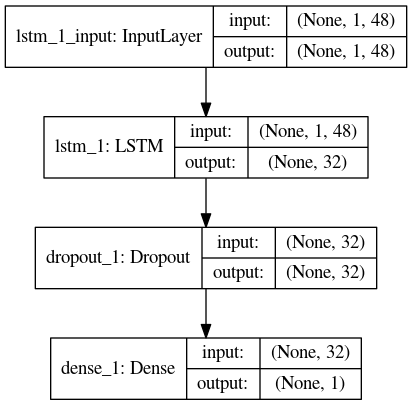

In [5]:
print('Build model...')
def create_lstm_v1(activation='relu', units=32, dropout=0.25, kernel_regularizer=None, kernel_initializer='glorot_uniform'):
    return Sequential([
                        LSTM(units, activation=activation, kernel_regularizer=kernel_regularizer, kernel_initializer=kernel_initializer, recurrent_dropout=0.2, input_shape=(1,48)),
                        Dropout(dropout),
                        Dense(1, activation='sigmoid')
                       ])

model = create_lstm_v1()
print(model.summary())
plot_model(model, to_file='lstm_modelv1.png', show_shapes=True)
Image.open('lstm_modelv1.png')

## 1.1 Splitting Dataset into Train/Test Sets (80%-20%)

In [6]:
X = df.drop(['id','CLASS_LABEL'], axis=1).values ## We are taking all columns except id and class_label as features of model.
Y = df[['CLASS_LABEL']].values ## We are taking class label as target variable.

## We are dividing dataset into train and test sets. Here random_state=123 refers to it'll produce same split each making it reproducible.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, stratify=Y, random_state=123) 
print('Train/Test Sizes : ',X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

Train/Test Sizes :  (8000, 48) (2000, 48) (8000, 1) (2000, 1)


## 1.1.1 Trying Default Model

Train on 7200 samples, validate on 800 samples
Epoch 1/10
7200/7200 [==============================] - 1s 186us/step - loss: 0.6200 - accuracy: 0.7169 - val_loss: 0.3409 - val_accuracy: 0.8775
Epoch 2/10
7200/7200 [==============================] - 1s 85us/step - loss: 0.3320 - accuracy: 0.8608 - val_loss: 0.2484 - val_accuracy: 0.9150
Epoch 3/10
7200/7200 [==============================] - 1s 83us/step - loss: 0.2671 - accuracy: 0.8869 - val_loss: 0.2000 - val_accuracy: 0.9212
Epoch 4/10
7200/7200 [==============================] - 1s 85us/step - loss: 0.2263 - accuracy: 0.9100 - val_loss: 0.1833 - val_accuracy: 0.9388
Epoch 5/10
7200/7200 [==============================] - 1s 82us/step - loss: 0.1997 - accuracy: 0.9207 - val_loss: 0.1721 - val_accuracy: 0.9362
Epoch 6/10
7200/7200 [==============================] - 1s 83us/step - loss: 0.1856 - accuracy: 0.9276 - val_loss: 0.1568 - val_accuracy: 0.9400
Epoch 7/10
7200/7200 [==============================] - 1s 85us/step - loss: 0.181

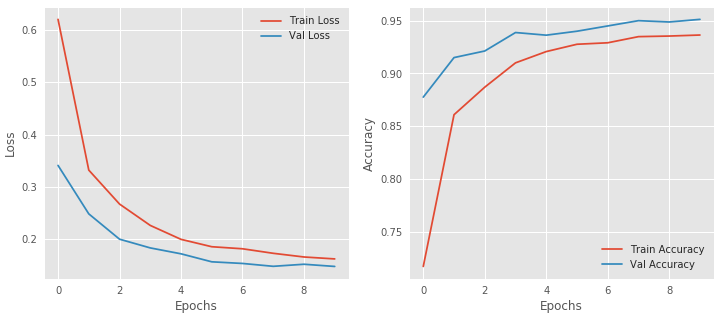

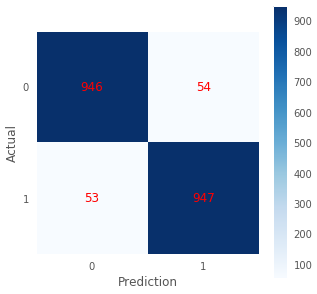

In [7]:
lstm_v1 = create_lstm_v1()
test_loss, test_acc, train_loss, train_acc = train_and_evaluate_model('LSTM', lstm_v1, figures=True, verbose=1)

## 1.1.2 Trying Various Hyperparameter Settings, activation funcs, loss functions, dropouts, etc

Below we are trying various hyperparametrs settings for model durding training and testing

**Activation Functions:**

Relu - $max(0,x)$

Tanh - Hyperbolic Tangent of x = $(e^{2x} - 1)/ (e^{2x} + 1)$

**Units:** 

We have tried 2 values of number of units to use for LSTM model 32, 50. We have tried values ofr units and feel that more than 50 units wil take more time for model to train and also it'll overfit to data giving more accuracy on train set and not fitting well with test data.

**Dropout:**

We are trying out various values ofr dropout like 205%, 30% and 50%. Dropout zeroes that many output from total output of layer to prevent model from overfitting.

**Optimizer:**

Adam - Adam is an adaptive learning rate optimization algorithm.The algorithms leverages the power of adaptive learning rates methods to find individual learning rates for each parameter.

Rmsprop - Its same as SGD with momentum. The RMSprop optimizer restricts the oscillations in the vertical direction. Therefore, we can increase our learning rate and our algorithm could take larger steps in the horizontal direction converging faster. 


**Regularization:**

l1 Regularization - It adds “absolute value of magnitude” of coefficient as penalty term to the loss function.It helps preventing model from overfitting.

l2 Regularization - It adds “squared magnitude” of coefficient as penalty term to the loss function. It prevents model from overfitting.

**Weights Initializations:**

Glorot Uniform - It finds a good variance for the distribution from which the initial parameters are drawn. This variance is adapted to the activation function used and is derived without explicitly considering the type of the distribution. 

Random Uniform - It randomly initializes weights.


In [8]:
%%time

results = []
for activation in ['relu', 'tanh']:
    for unit in [32,50]:
        for dropout in [0.25,0.30,0.50]:
            for opt in ['adam', 'rmsprop']:
                for kernel_regularizer in  ['l1', 'l2']:
                    for kernel_initializer in ['glorot_uniform','random_uniform']:
                        print('\nActivation : %s, Units : %d, Dropout : %.2f, Optimizer : %s, Regularization : %s, Weights Inits : %s'%(activation, unit, dropout, opt, kernel_regularizer, kernel_initializer))
                        lstm_v1 = create_lstm_v1(activation=activation, units=unit, dropout=dropout, kernel_regularizer=kernel_regularizer, kernel_initializer=kernel_initializer)
                        test_loss, test_acc, train_loss, train_acc = train_and_evaluate_model('LSTM', lstm_v1, optimizer=opt)
                        results.append([activation, unit, dropout, opt, kernel_regularizer, kernel_initializer, test_loss, test_acc, train_loss, train_acc])


Activation : relu, Units : 32, Dropout : 0.25, Optimizer : adam, Regularization : l1, Weights Inits : glorot_uniform

Test Loss: 0.433
Train Loss: 0.426
Test accuracy: 88.30
Train accuracy: 88.54

Activation : relu, Units : 32, Dropout : 0.25, Optimizer : adam, Regularization : l1, Weights Inits : random_uniform

Test Loss: 0.387
Train Loss: 0.382
Test accuracy: 91.25
Train accuracy: 91.96

Activation : relu, Units : 32, Dropout : 0.25, Optimizer : adam, Regularization : l2, Weights Inits : glorot_uniform

Test Loss: 0.248
Train Loss: 0.236
Test accuracy: 92.55
Train accuracy: 94.04

Activation : relu, Units : 32, Dropout : 0.25, Optimizer : adam, Regularization : l2, Weights Inits : random_uniform

Test Loss: 0.234
Train Loss: 0.223
Test accuracy: 93.55
Train accuracy: 94.54

Activation : relu, Units : 32, Dropout : 0.25, Optimizer : rmsprop, Regularization : l1, Weights Inits : glorot_uniform

Test Loss: 0.436
Train Loss: 0.434
Test accuracy: 89.15
Train accuracy: 88.35

Activation 

## 1.1.3 Displaying All Hyperparamters Combination Results as DataFrame

In [9]:
df1 = pd.DataFrame(results, columns=['Activation', 'Units', 'Dropout', 'Optimizer', 'Regularization', 'Weights Inits','Test Loss','Test Accuracy','Train Loss', 'Train Accuracy'])
df1.sort_values(by='Test Accuracy')

,Activation,Units,Dropout,Optimizer,Regularization,Weights Inits,Test Loss,Test Accuracy,Train Loss,Train Accuracy
16,relu,32,0.50,adam,l1,glorot_uniform,0.472377,0.8390,0.466409,0.848250
21,relu,32,0.50,rmsprop,l1,random_uniform,0.448161,0.8700,0.442948,0.875125
24,relu,50,0.25,adam,l1,glorot_uniform,0.431155,0.8800,0.422240,0.887125
85,tanh,50,0.30,rmsprop,l1,random_uniform,0.429221,0.8810,0.427225,0.871625
0,relu,32,0.25,adam,l1,glorot_uniform,0.433023,0.8830,0.426244,0.885375
...,...,...,...,...,...,...,...,...,...,...
35,relu,50,0.30,adam,l2,random_uniform,0.241088,0.9390,0.233067,0.941375
74,tanh,50,0.25,adam,l2,glorot_uniform,0.212116,0.9395,0.200311,0.946125
78,tanh,50,0.25,rmsprop,l2,glorot_uniform,0.208250,0.9410,0.196187,0.947000
63,tanh,32,0.30,rmsprop,l2,random_uniform,0.206687,0.9420,0.193878,0.945375


## 1.2 Splitting Dataset into Train/Test Sets (70%-30%)

In [10]:
X = df.drop(['id','CLASS_LABEL'], axis=1).values ## We are taking all columns except id and class_label as features of model.
Y = df[['CLASS_LABEL']].values ## We are taking class label as target variable.

## We are dividing dataset into train and test sets. Here random_state=123 refers to it'll produce same split each making it reproducible.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, test_size=0.3, stratify=Y, random_state=123) 
print('Train/Test Sizes : ',X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

Train/Test Sizes :  (7000, 48) (3000, 48) (7000, 1) (3000, 1)


## 1.2.1 Trying Default Model

Train on 6300 samples, validate on 700 samples
Epoch 1/10
6300/6300 [==============================] - 6s 965us/step - loss: 0.7903 - accuracy: 0.7006 - val_loss: 0.3015 - val_accuracy: 0.8929
Epoch 2/10
6300/6300 [==============================] - 1s 236us/step - loss: 0.3018 - accuracy: 0.8773 - val_loss: 0.2165 - val_accuracy: 0.9186
Epoch 3/10
6300/6300 [==============================] - 1s 229us/step - loss: 0.2282 - accuracy: 0.9119 - val_loss: 0.1778 - val_accuracy: 0.9329
Epoch 4/10
6300/6300 [==============================] - 1s 229us/step - loss: 0.1990 - accuracy: 0.9235 - val_loss: 0.1600 - val_accuracy: 0.9443
Epoch 5/10
6300/6300 [==============================] - 1s 229us/step - loss: 0.1871 - accuracy: 0.9268 - val_loss: 0.1558 - val_accuracy: 0.9414
Epoch 6/10
6300/6300 [==============================] - 1s 229us/step - loss: 0.1836 - accuracy: 0.9267 - val_loss: 0.1544 - val_accuracy: 0.9357
Epoch 7/10
6300/6300 [==============================] - 1s 223us/step - loss:

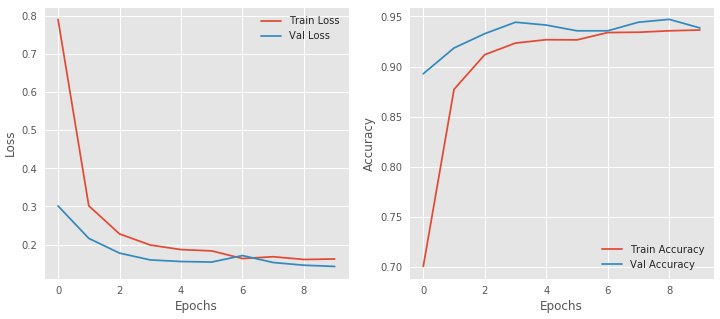

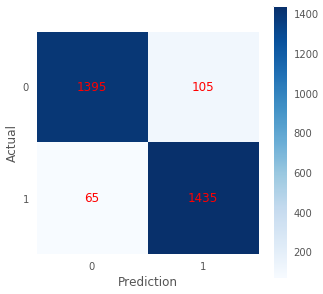

In [11]:
lstm_v1 = create_lstm_v1()
test_loss, test_acc, train_loss, train_acc = train_and_evaluate_model('LSTM', lstm_v1, figures=True, verbose=1)

## 1.2.2 Trying Various Hyperparameter Settings, activation funcs, loss functions, dropouts, etc

In [12]:
%%time

results = []
for activation in ['relu', 'tanh']:
    for unit in [32,50]:
        for dropout in [0.25,0.30,0.50]:
            for opt in ['adam', 'rmsprop']:
                for kernel_regularizer in  ['l1', 'l2']:
                    for kernel_initializer in ['glorot_uniform','random_uniform']:
                        print('\nActivation : %s, Units : %d, Dropout : %.2f, Optimizer : %s, Regularization : %s, Weights Inits : %s'%(activation, unit, dropout, opt, kernel_regularizer, kernel_initializer))
                        lstm_v1 = create_lstm_v1(activation=activation, units=unit, dropout=dropout, kernel_regularizer=kernel_regularizer, kernel_initializer=kernel_initializer)
                        test_loss, test_acc, train_loss, train_acc = train_and_evaluate_model('LSTM', lstm_v1, optimizer=opt)
                        results.append([activation, unit, dropout, opt, kernel_regularizer, kernel_initializer, test_loss, test_acc, train_loss, train_acc])


Activation : relu, Units : 32, Dropout : 0.25, Optimizer : adam, Regularization : l1, Weights Inits : glorot_uniform

Test Loss: 0.420
Train Loss: 0.417
Test accuracy: 89.37
Train accuracy: 90.07

Activation : relu, Units : 32, Dropout : 0.25, Optimizer : adam, Regularization : l1, Weights Inits : random_uniform

Test Loss: 0.378
Train Loss: 0.377
Test accuracy: 91.00
Train accuracy: 91.41

Activation : relu, Units : 32, Dropout : 0.25, Optimizer : adam, Regularization : l2, Weights Inits : glorot_uniform

Test Loss: 0.267
Train Loss: 0.259
Test accuracy: 91.83
Train accuracy: 92.54

Activation : relu, Units : 32, Dropout : 0.25, Optimizer : adam, Regularization : l2, Weights Inits : random_uniform

Test Loss: 0.241
Train Loss: 0.235
Test accuracy: 93.87
Train accuracy: 94.10

Activation : relu, Units : 32, Dropout : 0.25, Optimizer : rmsprop, Regularization : l1, Weights Inits : glorot_uniform

Test Loss: 0.524
Train Loss: 0.519
Test accuracy: 82.57
Train accuracy: 82.17

Activation 

## 1.2.3 Displaying All Hyperparamters Combination Results as DataFrame

In [13]:
df2 = pd.DataFrame(results, columns=['Activation', 'Units', 'Dropout', 'Optimizer', 'Regularization', 'Weights Inits','Test Loss','Test Accuracy','Train Loss', 'Train Accuracy'])
df2.sort_values(by='Test Accuracy')

,Activation,Units,Dropout,Optimizer,Regularization,Weights Inits,Test Loss,Test Accuracy,Train Loss,Train Accuracy
4,relu,32,0.25,rmsprop,l1,glorot_uniform,0.524274,0.825667,0.519103,0.821714
33,relu,50,0.30,adam,l1,random_uniform,0.430572,0.866333,0.432263,0.863857
64,tanh,32,0.50,adam,l1,glorot_uniform,0.426248,0.867667,0.423076,0.870000
37,relu,50,0.30,rmsprop,l1,random_uniform,0.465187,0.876000,0.463899,0.880143
20,relu,32,0.50,rmsprop,l1,glorot_uniform,0.477817,0.878000,0.475418,0.878286
...,...,...,...,...,...,...,...,...,...,...
58,tanh,32,0.30,adam,l2,glorot_uniform,0.216558,0.940333,0.210078,0.943429
54,tanh,32,0.25,rmsprop,l2,glorot_uniform,0.208823,0.940667,0.204636,0.942429
86,tanh,50,0.30,rmsprop,l2,glorot_uniform,0.208007,0.941333,0.204307,0.944286
94,tanh,50,0.50,rmsprop,l2,glorot_uniform,0.221521,0.941333,0.214497,0.941571


# 2. DenseNet Model
Below we have defined out deep learning model which consists of only dense layers (linear layers). We have defined 4 dense layers with units 256,128,64 and 1. Here units generally refers to that many nodes in that layers. Input to first layer will be array of shape (batch_size, 48) and it’ll go through all layers. Each layer has activation function as relu (max(val, 0)) which removes negative outputs after each layer performs its operation. Output layer is Dense layer with sigmoid function which will transfer output between (0,1.0). Each layers has parameters which are calculated as follows.

Dense Layer 1 = (input_size units) + biases = (48 256) + 256 = 12,544

Dense Layer 2 = (256 * 128) + 128 = 32,896 ( Please make a note that here input is 256 from Dense Layer 1)

Dense Layer 3 = (128 * 64) + 64 = 8,256

Dense Layer 4 = (64 * 1) + 1 = 65

Build model...
Model: "sequential_196"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_196 (Dense)            (None, 256)               12544     
_________________________________________________________________
dropout_196 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_197 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_197 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_198 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_198 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_199 (Dense)            (None, 1

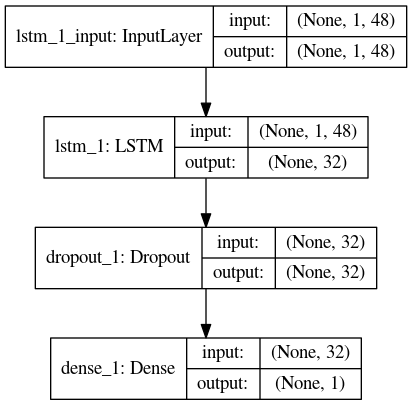

In [14]:
print('Build model...')
def create_dense_model(activation='relu', dropout=0.25, kernel_regularizer=None, kernel_initializer='glorot_uniform'):
    return Sequential( [Dense(256, activation=activation, kernel_regularizer=kernel_regularizer, kernel_initializer=kernel_initializer, input_shape=(48,)),
                        Dropout(dropout),
                        Dense(128, activation=activation, kernel_regularizer=kernel_regularizer, kernel_initializer=kernel_initializer),
                        Dropout(dropout),
                        Dense(64,activation=activation, kernel_regularizer=kernel_regularizer, kernel_initializer=kernel_initializer,),
                        Dropout(dropout),
                        Dense(1, activation='sigmoid')]
                      )

dense_model = create_dense_model()
print(dense_model.summary())
plot_model(model, to_file='dense_model.png', show_shapes=True )
Image.open('dense_model.png')

## 2.1 Splitting Dataset into Train/Test Sets (80%-20%)

In [15]:
X = df.drop(['id','CLASS_LABEL'], axis=1).values ## We are taking all columns except id and class_label as features of model.
Y = df[['CLASS_LABEL']].values ## We are taking class label as target variable.

## We are dividing dataset into train and test sets. Here random_state=123 refers to it'll produce same split each making it reproducible.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, stratify=Y, random_state=123) 
print('Train/Test Sizes : ',X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

Train/Test Sizes :  (8000, 48) (2000, 48) (8000, 1) (2000, 1)


## 2.1.1 Trying Default Model

Train on 7200 samples, validate on 800 samples
Epoch 1/10
7200/7200 [==============================] - 12s 2ms/step - loss: 0.8930 - accuracy: 0.5910 - val_loss: 0.5384 - val_accuracy: 0.7175
Epoch 2/10
7200/7200 [==============================] - 3s 378us/step - loss: 0.4489 - accuracy: 0.7958 - val_loss: 0.2685 - val_accuracy: 0.9050
Epoch 3/10
7200/7200 [==============================] - 3s 381us/step - loss: 0.3089 - accuracy: 0.8836 - val_loss: 0.2168 - val_accuracy: 0.9137
Epoch 4/10
7200/7200 [==============================] - 3s 377us/step - loss: 0.2311 - accuracy: 0.9139 - val_loss: 0.1740 - val_accuracy: 0.9325
Epoch 5/10
7200/7200 [==============================] - 3s 373us/step - loss: 0.2055 - accuracy: 0.9214 - val_loss: 0.1731 - val_accuracy: 0.9300
Epoch 6/10
7200/7200 [==============================] - 3s 369us/step - loss: 0.1785 - accuracy: 0.9336 - val_loss: 0.1665 - val_accuracy: 0.9362
Epoch 7/10
7200/7200 [==============================] - 3s 370us/step - loss: 

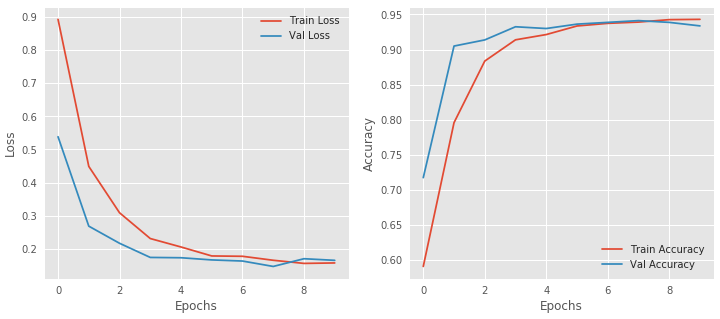

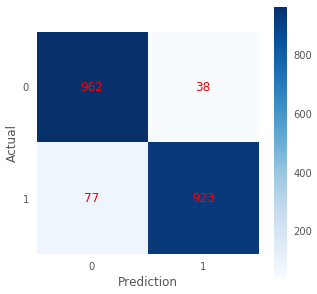

In [16]:
dense_model = create_dense_model()
test_loss, test_acc, train_loss, train_acc = train_and_evaluate_model('DenseNet', dense_model, figures=True, verbose=1)

## 2.1.2 Trying Various Hyperparameter Settings, activation funcs, loss functions, dropouts, etc

In [17]:
%%time

results = []
for activation in ['relu', 'tanh']:
    for dropout in [0.25,0.30,0.50]:
        for opt in ['adam', 'rmsprop']:
            for kernel_regularizer in  ['l1', 'l2']:
                for kernel_initializer in ['glorot_uniform','random_uniform']:
                    print('\nActivation : %s, Dropout : %.2f, Optimizer : %s, Regularization : %s, Weights Inits : %s'%(activation, dropout, opt, kernel_regularizer, kernel_initializer))
                    dense_model = create_dense_model(activation=activation, dropout=dropout, kernel_regularizer=kernel_regularizer, kernel_initializer=kernel_initializer)
                    test_loss, test_acc, train_loss, train_acc = train_and_evaluate_model('DenseNet', dense_model, optimizer=opt)
                    results.append([activation, dropout, opt, kernel_regularizer, kernel_initializer, test_loss, test_acc, train_loss, train_acc])


Activation : relu, Dropout : 0.25, Optimizer : adam, Regularization : l1, Weights Inits : glorot_uniform

Test Loss: 0.748
Train Loss: 0.748
Test accuracy: 50.00
Train accuracy: 50.00

Activation : relu, Dropout : 0.25, Optimizer : adam, Regularization : l1, Weights Inits : random_uniform

Test Loss: 0.759
Train Loss: 0.759
Test accuracy: 50.00
Train accuracy: 50.00

Activation : relu, Dropout : 0.25, Optimizer : adam, Regularization : l2, Weights Inits : glorot_uniform

Test Loss: 0.288
Train Loss: 0.276
Test accuracy: 93.80
Train accuracy: 94.41

Activation : relu, Dropout : 0.25, Optimizer : adam, Regularization : l2, Weights Inits : random_uniform

Test Loss: 0.244
Train Loss: 0.226
Test accuracy: 93.45
Train accuracy: 94.75

Activation : relu, Dropout : 0.25, Optimizer : rmsprop, Regularization : l1, Weights Inits : glorot_uniform

Test Loss: 0.958
Train Loss: 0.958
Test accuracy: 50.00
Train accuracy: 50.00

Activation : relu, Dropout : 0.25, Optimizer : rmsprop, Regularization 

## 2.1.3 Displaying All Hyperparamters Combination Results as DataFrame

In [18]:
df5 = pd.DataFrame(results, columns=['Activation', 'Dropout', 'Optimizer', 'Regularization', 'Weights Inits','Test Loss','Test Accuracy','Train Loss', 'Train Accuracy'])
df5.sort_values(by='Test Accuracy')

,Activation,Dropout,Optimizer,Regularization,Weights Inits,Test Loss,Test Accuracy,Train Loss,Train Accuracy
0,relu,0.25,adam,l1,glorot_uniform,0.747823,0.5000,0.747823,0.500000
25,tanh,0.25,adam,l1,random_uniform,0.757358,0.5000,0.757358,0.500000
17,relu,0.50,adam,l1,random_uniform,0.757993,0.5000,0.757993,0.500000
16,relu,0.50,adam,l1,glorot_uniform,0.745287,0.5000,0.745287,0.500000
29,tanh,0.25,rmsprop,l1,random_uniform,0.957285,0.5000,0.957285,0.500000
33,tanh,0.30,adam,l1,random_uniform,0.757454,0.5000,0.757454,0.500000
13,relu,0.30,rmsprop,l1,random_uniform,0.955378,0.5000,0.955378,0.500000
12,relu,0.30,rmsprop,l1,glorot_uniform,0.959054,0.5000,0.959054,0.500000
36,tanh,0.30,rmsprop,l1,glorot_uniform,0.960200,0.5000,0.960200,0.500000
21,relu,0.50,rmsprop,l1,random_uniform,0.957195,0.5000,0.957195,0.500000


## 2.2 Splitting Dataset into Train/Test Sets (70%-30%)

In [19]:
X = df.drop(['id','CLASS_LABEL'], axis=1).values ## We are taking all columns except id and class_label as features of model.
Y = df[['CLASS_LABEL']].values ## We are taking class label as target variable.

## We are dividing dataset into train and test sets. Here random_state=123 refers to it'll produce same split each making it reproducible.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, test_size=0.3, stratify=Y, random_state=123) 
print('Train/Test Sizes : ',X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

Train/Test Sizes :  (7000, 48) (3000, 48) (7000, 1) (3000, 1)


## 2.2.1 Trying Default Model

Train on 6300 samples, validate on 700 samples
Epoch 1/10
6300/6300 [==============================] - 15s 2ms/step - loss: 0.7529 - accuracy: 0.6094 - val_loss: 0.4845 - val_accuracy: 0.8229
Epoch 2/10
6300/6300 [==============================] - 3s 469us/step - loss: 0.4109 - accuracy: 0.8214 - val_loss: 0.2588 - val_accuracy: 0.8871
Epoch 3/10
6300/6300 [==============================] - 3s 469us/step - loss: 0.2688 - accuracy: 0.8965 - val_loss: 0.2208 - val_accuracy: 0.9114
Epoch 4/10
6300/6300 [==============================] - 3s 473us/step - loss: 0.2149 - accuracy: 0.9197 - val_loss: 0.1754 - val_accuracy: 0.9329
Epoch 5/10
6300/6300 [==============================] - 3s 476us/step - loss: 0.1920 - accuracy: 0.9289 - val_loss: 0.1741 - val_accuracy: 0.9357
Epoch 6/10
6300/6300 [==============================] - 3s 478us/step - loss: 0.1897 - accuracy: 0.9276 - val_loss: 0.1604 - val_accuracy: 0.9443
Epoch 7/10
6300/6300 [==============================] - 3s 472us/step - loss: 

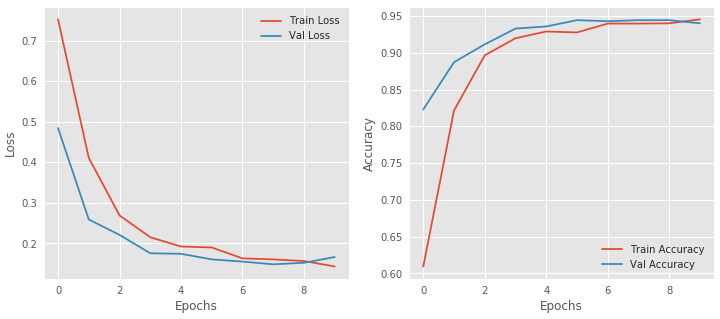

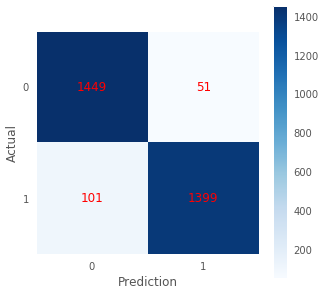

In [20]:
dense_model = create_dense_model()
test_loss, test_acc, train_loss, train_acc = train_and_evaluate_model('DenseNet', dense_model, figures=True, verbose=1)

## 2.2.2 Trying Various Hyperparameter Settings, activation funcs, loss functions, dropouts, etc

In [21]:
%%time

results = []
for activation in ['relu', 'tanh']:
    for dropout in [0.25,0.30,0.50]:
        for opt in ['adam', 'rmsprop']:
            for kernel_regularizer in  ['l1', 'l2']:
                for kernel_initializer in ['glorot_uniform','random_uniform']:
                    print('\nActivation : %s, Dropout : %.2f, Optimizer : %s, Regularization : %s, Weights Inits : %s'%(activation, dropout, opt, kernel_regularizer, kernel_initializer))
                    dense_model = create_dense_model(activation=activation, dropout=dropout, kernel_regularizer=kernel_regularizer, kernel_initializer=kernel_initializer)
                    test_loss, test_acc, train_loss, train_acc = train_and_evaluate_model('DenseNet', dense_model, optimizer=opt)
                    results.append([activation, dropout, opt, kernel_regularizer, kernel_initializer, test_loss, test_acc, train_loss, train_acc])


Activation : relu, Dropout : 0.25, Optimizer : adam, Regularization : l1, Weights Inits : glorot_uniform

Test Loss: 0.748
Train Loss: 0.748
Test accuracy: 50.00
Train accuracy: 50.00

Activation : relu, Dropout : 0.25, Optimizer : adam, Regularization : l1, Weights Inits : random_uniform

Test Loss: 0.758
Train Loss: 0.758
Test accuracy: 50.00
Train accuracy: 50.00

Activation : relu, Dropout : 0.25, Optimizer : adam, Regularization : l2, Weights Inits : glorot_uniform

Test Loss: 0.340
Train Loss: 0.330
Test accuracy: 92.70
Train accuracy: 93.17

Activation : relu, Dropout : 0.25, Optimizer : adam, Regularization : l2, Weights Inits : random_uniform

Test Loss: 0.254
Train Loss: 0.245
Test accuracy: 94.10
Train accuracy: 94.37

Activation : relu, Dropout : 0.25, Optimizer : rmsprop, Regularization : l1, Weights Inits : glorot_uniform

Test Loss: 0.960
Train Loss: 0.960
Test accuracy: 50.00
Train accuracy: 50.00

Activation : relu, Dropout : 0.25, Optimizer : rmsprop, Regularization 

## 2.2.3 Displaying All Hyperparamters Combination Results as DataFrame

In [22]:
df6 = pd.DataFrame(results, columns=['Activation', 'Dropout', 'Optimizer', 'Regularization', 'Weights Inits','Test Loss','Test Accuracy','Train Loss', 'Train Accuracy'])
df6.sort_values(by='Test Accuracy')

,Activation,Dropout,Optimizer,Regularization,Weights Inits,Test Loss,Test Accuracy,Train Loss,Train Accuracy
0,relu,0.25,adam,l1,glorot_uniform,0.747926,0.500000,0.747926,0.500000
32,tanh,0.30,adam,l1,glorot_uniform,0.751294,0.500000,0.751294,0.500000
29,tanh,0.25,rmsprop,l1,random_uniform,0.960381,0.500000,0.960381,0.500000
37,tanh,0.30,rmsprop,l1,random_uniform,0.958879,0.500000,0.958879,0.500000
40,tanh,0.50,adam,l1,glorot_uniform,0.750703,0.500000,0.750703,0.500000
25,tanh,0.25,adam,l1,random_uniform,0.757640,0.500000,0.757640,0.500000
41,tanh,0.50,adam,l1,random_uniform,0.756831,0.500000,0.756831,0.500000
21,relu,0.50,rmsprop,l1,random_uniform,0.955601,0.500000,0.955601,0.500000
20,relu,0.50,rmsprop,l1,glorot_uniform,0.958831,0.500000,0.958831,0.500000
33,tanh,0.30,adam,l1,random_uniform,0.757488,0.500000,0.757488,0.500000


## Saving All Outputs to Excel & Presenting as Link to Download

In [23]:
with pd.ExcelWriter('Final_Output.xlsx') as writer:
    for sheet_name, df in [('LSTMv1_1',df1), ('LSTMv1_2',df2), ('DenseNet_1', df5), ('DenseNet_2', df6)]:
        df.to_excel(writer, sheet_name= sheet_name)

In [24]:
FileLink('Final_Output.xlsx')

/kaggle/working/Final_Output.xlsx

In [25]:
FileLink('lstm_modelv1.png')

/kaggle/working/lstm_modelv1.png

In [26]:
FileLink('lstm_modelv2.png')

/kaggle/working/lstm_modelv2.png

In [27]:
FileLink('dense_model.png')

/kaggle/working/dense_model.png

In [28]:
FileLink('loss_and_acc.png')

/kaggle/working/loss_and_acc.png

In [29]:
FileLink('conf_mat.png')

/kaggle/working/conf_mat.png